**MSFT** - Microsoft Corporation \
**TSLA** - Tesla \
**COKE** - Coca-Cola Consolidated, Inc.  \
**INTC** - Intel Corporation  

In [8]:
# Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import DateFormatter
import yfinance as yf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [59]:

stocks = ['MSFT', 'TSLA', 'COKE', 'INTC']

start_data = '2016-10-01'  # (RRR-MM-DD)
end_data = '2021-10-01'  # (RRR-MM-DD)

for stock in stocks:
    data = yf.download(stock, start_data, end_data)
    df = pd.DataFrame(data)
    df['Name'] = stock  # add column with symbol
    df.to_csv(stock + '.csv')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [64]:
# Merge multiple csv files
import glob

os.chdir('C:/Users/Karolina/Desktop/PYTHON/') # CHANGE ME 
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
# Combine all files in the list
price_data = pd.concat([pd.read_csv(f) for f in all_filenames ])
# Export to csv
price_data.to_csv( "price_data.csv", index=False, encoding='utf-8-sig')




In [65]:
# Convert 'Date'
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data = price_data.set_index('Date')
start, end = '2016-10', '2021-10'
pd.set_option('display.max_columns', None)


In [69]:
price_data.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2016-10-03,147.520004,147.589996,144.330002,145.119995,137.500824,72700,COKE
2016-10-04,145.600006,146.399994,142.529999,143.490005,135.956467,59700,COKE
2016-10-05,144.289993,144.639999,140.070007,141.440002,134.014084,284000,COKE
2016-10-06,141.529999,143.410004,140.509995,142.500000,135.018433,94200,COKE
2016-10-07,142.460007,143.300003,140.789993,141.470001,134.042542,99500,COKE


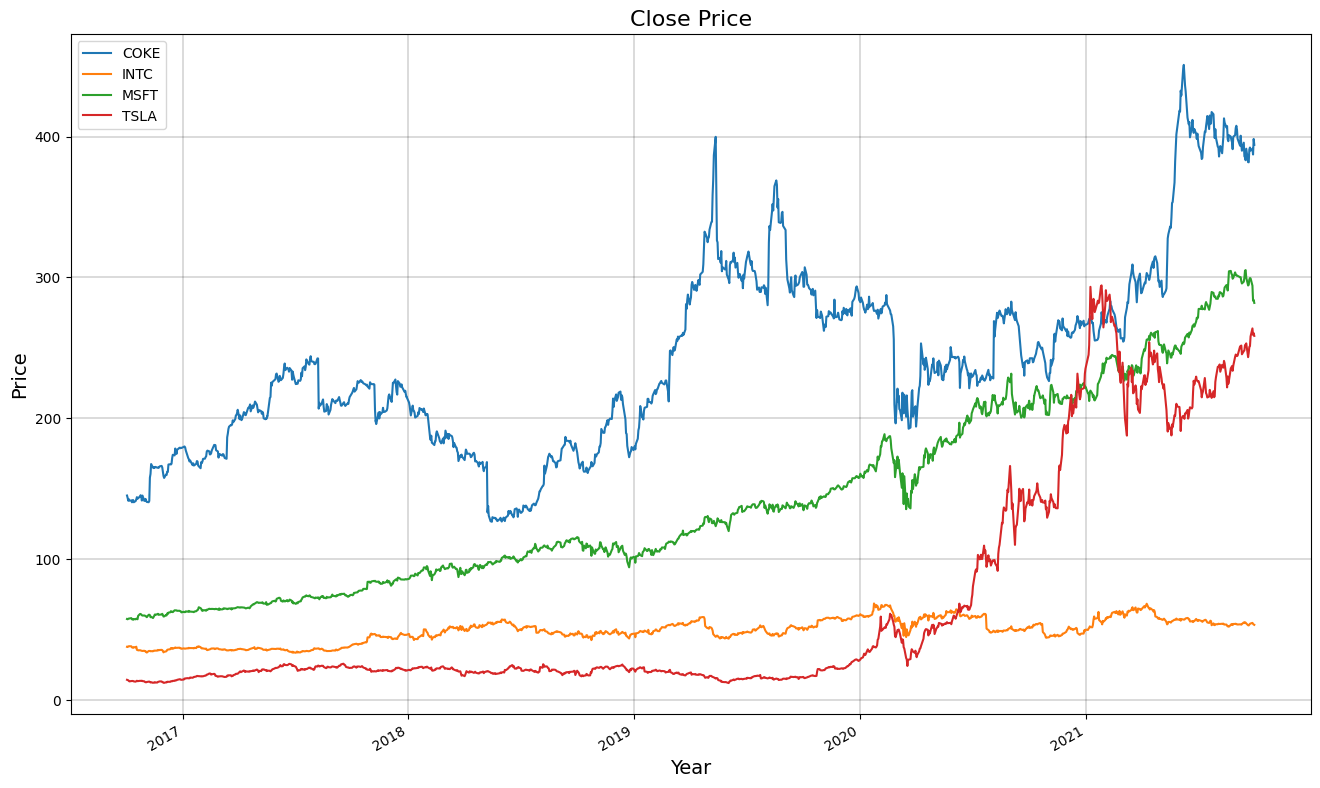

In [70]:
# Create placeholder for data
data = pd.DataFrame(columns=stocks)

# Fetch the data
for stock in stocks:
    data[stock] = pd.read_csv(stock + '.csv')['Close']
    
# Plot all the close prices
price_data.groupby('Name')['Close'].plot(figsize=(16, 10))

# Show the legend
plt.legend(loc = 'upper left')

# Define the label for the title of the figure
plt.title("Close Price", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-', linewidth=0.2)

plt.show()

In [71]:
# Load all data
price_data = pd.read_csv('price_data.csv')

# Return

In [72]:
# Calculate return
price_data['Return'] = price_data.groupby('Name')['Close'].transform(lambda x: x.diff())

# diff() -> x - (x-1)

In [73]:
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return
0,2016-10-03,147.520004,147.589996,144.330002,145.119995,137.500824,72700,COKE,NaN
1,2016-10-04,145.600006,146.399994,142.529999,143.490005,135.956467,59700,COKE,-1.629990
2,2016-10-05,144.289993,144.639999,140.070007,141.440002,134.014084,284000,COKE,-2.050003
3,2016-10-06,141.529999,143.410004,140.509995,142.500000,135.018433,94200,COKE,1.059998
4,2016-10-07,142.460007,143.300003,140.789993,141.470001,134.042542,99500,COKE,-1.029999


# Gain/lose

In [74]:
# Set '0' if 'Up' is below 0
price_data['Up'] = price_data['Return']
price_data.loc[(price_data['Up']<0), 'Up'] = 0

# Set '0' if 'Down' above 0
price_data['Down'] = price_data['Return']
price_data.loc[(price_data['Down']>0), 'Down'] = 0 

# Set the absolute value for negative values
price_data['Down'] = abs(price_data['Down'])

# Average gain/loss

In [75]:
# 14-days averages

price_data['avg_14up'] = price_data.groupby('Name')['Up'].transform(lambda x: x.rolling(window=14).mean())
price_data['avg_14down'] = price_data.groupby('Name')['Down'].transform(lambda x: x.rolling(window=14).mean())

# RSI

 $RSI = 100 + \frac{100}{1-RS}$
 
$RS = \frac{Average \ Gain \ Over \ past \ 14 \ days}{Average \ Loss \ Over \ past \ 14 \ days}$

In [76]:
# Calculate RS

price_data['RS_14'] = price_data['avg_14up'] / price_data['avg_14down']

# Calculate RSI

price_data['RSI'] = 100 - (100/(1 + price_data['RS_14']))


## EWMA


In [77]:


n = 14
# Calculate  EWMA 

price_data['EWMA_up'] = price_data.groupby('Name')['Return'].transform(lambda x: x.ewm(span = n).mean())
price_data['EWMA_down'] = price_data.groupby('Name')['Return'].transform(lambda x: x.ewm(span = n).mean())


# Moving Average Convergence Divergence (MACD)

$ MACD = EMA_{12}(C_{t}) - EMA_{26}(C_{t}) $ 

   $ C_{t} = current \ close \ price $

In [78]:
# Calculate 12 and 26 EWM
price_data['12Ewm'] = price_data.groupby('Name')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
price_data['26Ewm'] = price_data.groupby('Name')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

# Calculate MACD
price_data['MACD'] = price_data['12Ewm'] - price_data['26Ewm']

# Stochastic Oscillator
   $ K = 100 * \frac{C_{t}-L_{14}}{H_{14}-L_{14}} $
    
   $ C_{t} = current \ close \ price $

In [79]:
# Period
n = 14

# Group by the symbol and then take max and min 
price_data['low_14'] = price_data.groupby('Name')['Low'].transform(lambda x: x.rolling(window = n).min())
price_data['high_14'] = price_data.groupby('Name')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the stochastic oscillator
price_data['k_percent']  = 100 * ((price_data['Close'] - price_data['low_14']) / (price_data['high_14'] - price_data['low_14']))

# Williams %R
$ R = \frac{(H_{14} - C_{t})}{(H_{14} - L_{14})} * -100 $

   $ C_{t} = current \ close \ price $


In [80]:
# Williams %R
price_data['r_percent'] = ((price_data['high_14'] - price_data['Close']) / (price_data['high_14'] - price_data['low_14'])) * - 100

# Rate Of Change
$ PROC_{(t)} = \frac{C_{(t)} - C_{(t - n)}}{C_{(t - n)}} $

   $ C_{t} = current \ close \ price $

In [81]:
# ROC
n = 9

price_data['ROC'] = price_data.groupby('Name')['Close'].transform(lambda x: x.pct_change(periods = n))

# On Balance Volume (OBV)

$OBV=\begin{cases}
    Previous \ OBV + Current \ Day’s \ Volume, & \text{$if \ close > close_{prev}$}\\
    Previous \ OBV, & \text{$if \ close = close_{prev}$} \\
    Previous \ OBV - Current \ Day’s \ Volume, & \text{$if \ close < close_{prev}$}
  \end{cases} $

In [83]:

def obv(group):

    # Grab the volume and close column
    volume = group['Volume']
    change = group['Close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate OBV
    for i, j in zip(change, volume):  # zip 2 values and loop for each row and column  

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
        
    # Return a panda series
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = price_data.groupby('Name').apply(obv)

# add to the data frame, but drop the old index, before adding it
price_data['OBV'] = obv_groups.reset_index(level=0, drop=True)



### LOAD / SAVE FILE

In [87]:
# To csv file
#price_data.to_csv("beforeModel.csv")

# Read file
price_data = pd.read_csv("beforeModel.csv")

# Create the Prediction Column

In [85]:
#price_data['Target'] = price_data.groupby('Name')['Return'].transform(lambda x : x.shift(periods =-1) < 0)
# price_data['Target'] = price_data.groupby('Name')['Return'].transform(lambda x : -1 if x < 0 else 1 if x > 0 else 0 if x == 0)

price_data['Target'] = price_data.groupby('Name')['Close'].transform(lambda x : x.diff() < 0)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return,Up,Down,avg_14up,avg_14down,RS_14,RSI,EWMA_up,EWMA_down,12Ewm,26Ewm,MACD,low_14,high_14,k_percent,r_percent,ROC,OBV,Target
0,2016-10-03,147.520004,147.589996,144.330002,145.119995,137.500824,72700,COKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.119995,145.119995,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,False
1,2016-10-04,145.600006,146.399994,142.529999,143.490005,135.956467,59700,COKE,-1.629990,0.000000,1.629990,NaN,NaN,NaN,NaN,-1.629990,-1.629990,144.869227,144.999255,-0.130028,NaN,NaN,NaN,NaN,NaN,-59700.0,True
2,2016-10-05,144.289993,144.639999,140.070007,141.440002,134.014084,284000,COKE,-2.050003,0.000000,2.050003,NaN,NaN,NaN,NaN,-1.854997,-1.854997,144.341654,144.735607,-0.393952,NaN,NaN,NaN,NaN,NaN,-343700.0,True
3,2016-10-06,141.529999,143.410004,140.509995,142.500000,135.018433,94200,COKE,1.059998,1.059998,0.000000,NaN,NaN,NaN,NaN,-0.741459,-0.741459,144.058323,144.570006,-0.511683,NaN,NaN,NaN,NaN,NaN,-249500.0,False
4,2016-10-07,142.460007,143.300003,140.789993,141.470001,134.042542,99500,COKE,-1.029999,0.000000,1.029999,NaN,NaN,NaN,NaN,-0.829732,-0.829732,143.660120,144.340376,-0.680257,NaN,NaN,NaN,NaN,NaN,-349000.0,True


##  Remove `NaN` values

In [92]:
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Delete lines with NaN values
price_data = price_data.dropna()

# Display how much we have left now
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# price_data.head()

Before NaN Drop we have 45232 rows and 28 columns
After NaN Drop we have 45228 rows and 28 columns


## Create the Prediction Column


In [90]:
price_data['Target'] = price_data.groupby('Name')['Close'].transform(lambda x : np.sign(x.diff()))

### Final metrics

In [97]:
price_data.to_csv('final_metrics.csv')

In [96]:
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return,Up,Down,avg_14up,avg_14down,RS_14,RSI,EWMA_up,EWMA_down,12Ewm,26Ewm,MACD,low_14,high_14,k_percent,r_percent,ROC,OBV,Target
15,2016-10-24,144.550003,144.630005,143.179993,144.559998,136.970291,25900,COKE,1.399994,1.399994,0.000000,0.574284,0.497856,1.153514,53.564273,0.287613,0.287613,142.893702,143.260398,-0.366697,137.220001,144.789993,96.961744,-3.038256,0.030363,-79900.0,1.0
16,2016-10-25,144.940002,145.910004,144.279999,145.339996,137.709351,27200,COKE,0.779999,0.779999,0.000000,0.629998,0.351427,1.792684,64.192159,0.360665,0.360665,143.270055,143.414443,-0.144388,137.220001,145.910004,93.440654,-6.559346,0.025037,-52700.0,1.0
17,2016-10-26,145.789993,146.979996,144.080002,144.470001,137.120850,46800,COKE,-0.869995,0.000000,0.869995,0.554284,0.413570,1.340243,57.269400,0.180783,0.180783,143.454662,143.492632,-0.037970,137.220001,146.979996,74.282829,-25.717171,0.018327,-99500.0,-1.0
18,2016-10-27,144.839996,145.039993,140.710007,141.559998,134.358902,103900,COKE,-2.910004,0.000000,2.910004,0.554284,0.547856,1.011734,50.291629,-0.265262,-0.265262,143.163175,143.349474,-0.186299,137.220001,146.979996,44.467201,-55.532799,0.008621,-203400.0,-1.0
19,2016-10-28,141.520004,145.419998,141.520004,145.089996,137.709259,86800,COKE,3.529999,3.529999,0.000000,0.798570,0.547856,1.457627,59.310350,0.276500,0.276500,143.459609,143.478402,-0.018793,137.220001,146.979996,80.635241,-19.364759,0.027331,-116600.0,1.0


In [95]:
#price_data = price_data.drop(['Unnamed: 0'], axis=1) # drop redundant column

In [98]:
# oddzielenie spółek do oddzielnych plików

for company_name in price_data['Name'].unique():
    # Wybierz dane dla danej spółki
    company_data = price_data[price_data['Name'] == company_name]
    # Zapisz dane do osobnego pliku CSV
    company_data.to_csv(f'{company_name}.csv', index=False)